In [13]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from symmetry_no.fno2d import FNO2dSemiLinear
from symmetry_no.GRF import GaussianRF
from symmetry_no.darcy_utilities import DarcyExtractBC



In [14]:

size = 1024
grid = torch.linspace(0,1,size)
X,Y = torch.meshgrid(grid,grid,indexing='ij')

dim = 2
grf = GaussianRF(dim=dim,size=2*size,alpha=2,tau=8)
Nsamp = 1
channels = 5
x = grf.sample(Nsamp*channels).view(Nsamp,channels,2*size,2*size)
x = x[:,:,:size,:size]
x = DarcyExtractBC(x,x)

modes = 12
width = 64
model = FNO2dSemiLinear(modes,modes,width,in_channel=1,out_channel=1)


In [15]:
# extract BC
x_ = x.clone()
BC_left   = x_[:,1, 0, :].unsqueeze(1) # shape: (B, 1, s)    
BC_bottom = x_[:,2, :, 0].unsqueeze(1)
BC_right  = x_[:,3,-1, :].unsqueeze(1)
BC_top    = x_[:,4, :,-1].unsqueeze(1)
# combine all BC's
BC = torch.cat((BC_left, BC_bottom, BC_right, BC_top), dim=1)

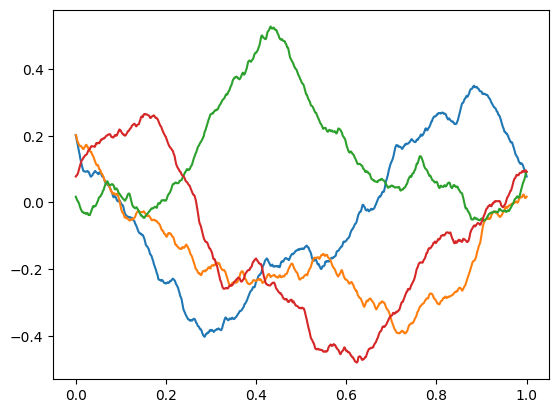

In [16]:
plt.figure()
grid = torch.linspace(0,1,BC.shape[-1])
plt.plot(grid, BC[0,:,:].T)
plt.show()

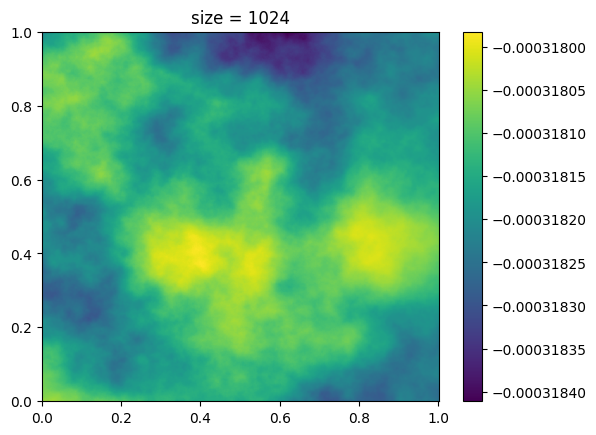

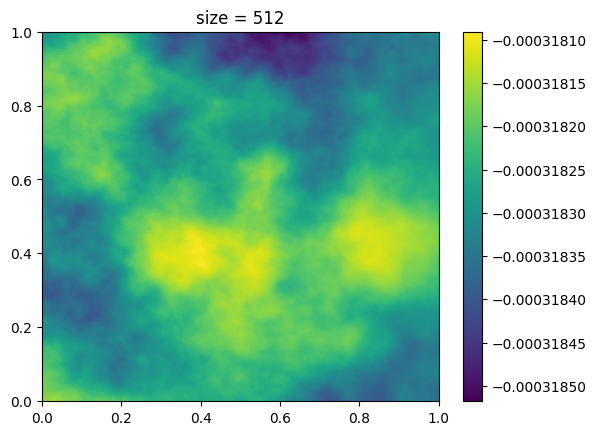

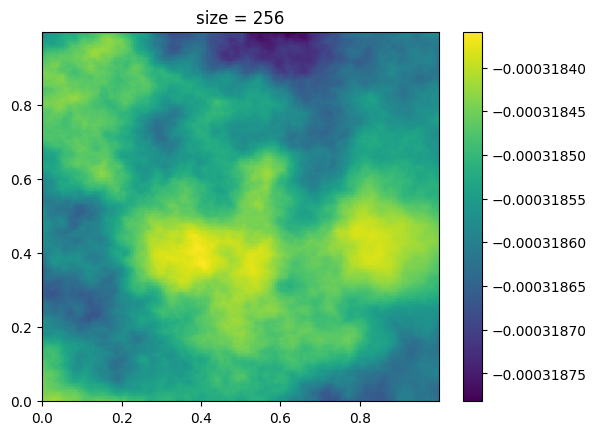

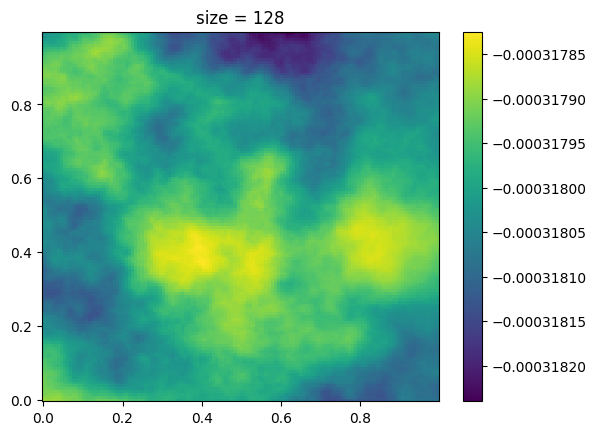

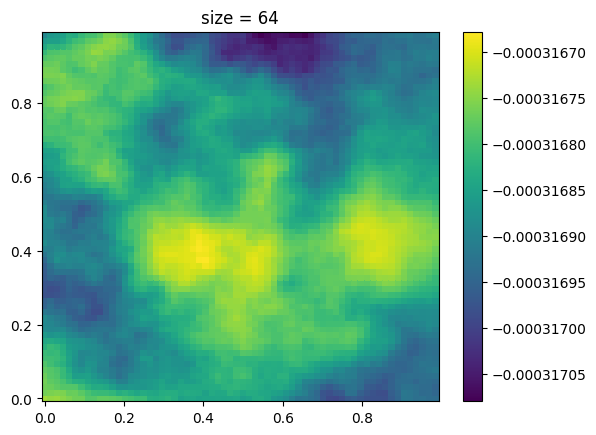

In [17]:
norm_vals = []
err_vals = []
N_vals = []
pred_prev = None

for ss in [1,2,4,8,16]:
    xss = x[:,:,::ss,::ss]
    Xss = X[::ss,::ss]
    Yss = Y[::ss,::ss]

    #
    pred_new = model(xss).detach().squeeze()
    if ss>1:
        norm_vals.append( pred_new.abs().mean() )
        err_vals.append( (pred_new - pred_prev[::2,::2]).abs().mean() )
        N_vals.append( size // ss )
    pred_prev = pred_new
    
    #
    plt.figure()
    plt.pcolor(Xss,Yss,pred_new.squeeze())
    plt.colorbar()
    plt.title(f'size = {size//ss}')
    plt.show()


In [18]:
# normalize 
err_vals_n = [x/norm_vals[0] for x in err_vals]
norm_vals_n = [x/norm_vals[0] for x in norm_vals]


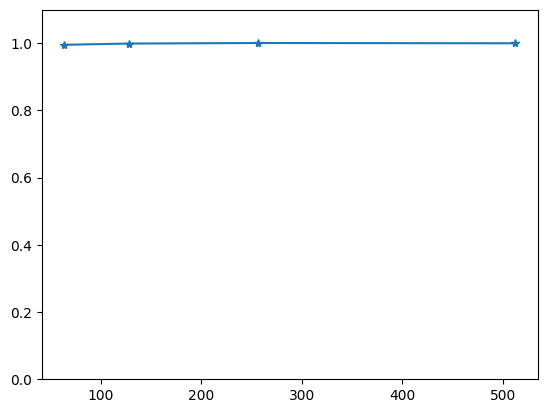

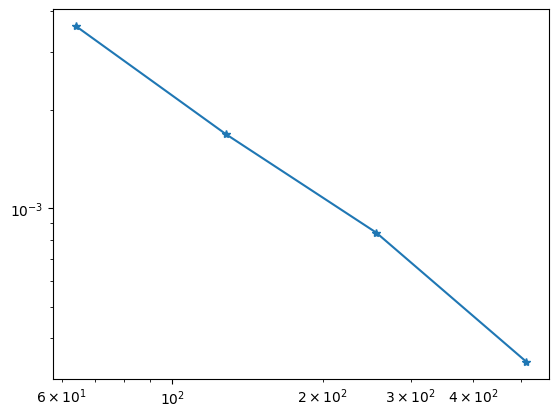

In [19]:
plt.figure()
plt.plot(N_vals, norm_vals_n, '*-')
plt.ylim([0,1.1])
plt.show()

plt.figure()
plt.loglog(N_vals, err_vals_n, '*-')
plt.show()